# Semivariogram regularization - tutorial

## Table of Contents:

1. Prepare areal and point data,
2. Set semivariogram parameters,
3. Perform regularization,
4. Visualize regularized semivariogram and analyze algorithm performance,
5. Export semivariogram to text file.

## Level: Intermediate

## Introduction

In this tutorial we learn how to regularize semivariogram of areal dataset of irregular polygons. Procedure is described here: (1) Goovaerts P., Kriging and Semivariogram Deconvolution in the Presence of Irregular Geographical Units, Mathematical Geology 40(1), 101-128, 2008. 

The main idea is to retrieve point support semivariogram from semivariogram of areal data with blocks of different shapes and sizes. It is the case in mining industry, where blocks of aggregates are deconvoluted into smaller units and in the epidemiology, where data is usually aggregated over big administrative units, or in ecology, where observations of species are aggregated over areas or time windows.

In this tutorial we use areal data of road accidents per county in Poland along with the point support data of population smaller support blocks.

> Road accidents data is stored in the shapefile in folder 'sample_data/areal_data/road_accidents.shp'

> Population blocks data is stored in the shapefile in folder 'sample_data/population_data/population_centroids_poland.shp'

## Import packages

In [18]:
import numpy as np
import geopandas as gpd

from pyinterpolate import prepare_areal_shapefile  # Prepare data
from pyinterpolate import get_points_within_area  # Prepare data
from pyinterpolate import calculate_semivariance  # Experimental semivariogram
from pyinterpolate import RegularizedSemivariogram  # Semivariogram regularization class

import matplotlib.pyplot as plt

## 1) Prepare areal and point data

In [4]:
areal_data = '../sample_data/areal_data/road_accidents.shp'
point_data = '../sample_data/population_data/population_centroids_poland.shp'

# The important thing before analysis is to check if crs of areal data and point data are the same

areal_crs = gpd.read_file(areal_data).crs
point_support_crs = gpd.read_file(point_data).crs

areal_crs == point_support_crs

True

In [8]:
# We need to know:
# - id column name of areal units,
# - value column name of areal units (usually aggregates),
# - value column name of point support units (usually population)

# Let's check it quickly with geopandas

areal = gpd.read_file(areal_data)
areal.head()

,ID,VOIVOD,NAME,deaths,inh,rate,geometry
0,915,podkarpackie,powiat ropczycko-sÄdziszowski,3,74198,0.040432,"POLYGON ((692305.365 260282.248, 692313.646 26..."
1,710,mazowieckie,powiat Åosicki,6,31335,0.191479,"POLYGON ((753920.175 497017.076, 753918.822 49..."
2,718,mazowieckie,powiat piaseczyÅski,15,182076,0.082383,"POLYGON ((644442.384 473992.041, 644345.678 47..."
3,727,mazowieckie,powiat sierpecki,7,52559,0.133184,"POLYGON ((534236.749 555932.727, 534235.027 55..."
4,730,mazowieckie,powiat szydÅowiecki,4,39938,0.100155,"POLYGON ((625514.215 384549.238, 625545.119 38..."


In [9]:
# From areal file we are interested in variable deaths (value) and ID (id)
# Now check point support data

point = gpd.read_file(point_data)
point.head()

,TOT,geometry
0,0,POINT (445700.430 775061.580)
1,13,POINT (449649.816 774784.622)
2,1270,POINT (454573.872 774546.994)
3,95,POINT (457672.822 774072.742)
4,0,POINT (425378.686 772864.038)


In [10]:
# Column TOT is interesting from our perspective
# Now prepare data for further processing

areal_id = 'ID'
areal_val = 'deaths'
points_val = 'TOT'

areal_data_prepared = prepare_areal_shapefile(areal_data, areal_id, areal_val)

In [11]:
# Check how prepared areal data looks like

areal_data_prepared[0]

array([915, <shapely.geometry.polygon.Polygon object at 0x7f5be0e95510>,
       689225.7862175289, 245704.52509337224, 3], dtype=object)

### Clarification:

Every areal dataset is passed as an array of:

[area id, area geometry (polygon), areal centroid x (lon), areal centroid y (lat), value]

In [13]:
points_in_area = get_points_within_area(areal_data, point_data, areal_id_col_name=areal_id,
                                        points_val_col_name=points_val)

In [14]:
# Check how prepared point data looks like

points_in_area[0]

array([1112.0,
       array([[4.49649816e+05, 7.74784622e+05, 1.30000000e+01],
       [4.54573872e+05, 7.74546994e+05, 1.27000000e+03],
       [4.57672822e+05, 7.74072742e+05, 9.50000000e+01],
       [4.34132306e+05, 7.73217942e+05, 5.81000000e+02],
       [4.39115084e+05, 7.73011892e+05, 1.99000000e+02],
       [4.44027632e+05, 7.72564517e+05, 7.50000000e+02],
       [4.48983771e+05, 7.71947376e+05, 2.57400000e+03],
       [4.53943595e+05, 7.71324042e+05, 1.21200000e+03],
       [4.58775918e+05, 7.70575412e+05, 6.34600000e+03],
       [4.33469881e+05, 7.68864048e+05, 1.92600000e+03],
       [4.43389339e+05, 7.67616758e+05, 1.94300000e+03],
       [4.48349167e+05, 7.66993362e+05, 1.99000000e+03],
       [4.53309065e+05, 7.66370130e+05, 2.74500000e+03],
       [4.58269037e+05, 7.65747062e+05, 2.90200000e+03],
       [4.73064428e+05, 7.63569749e+05, 6.22000000e+02],
       [4.76799027e+05, 7.61514013e+05, 0.00000000e+00],
       [4.42754940e+05, 7.62662657e+05, 9.23000000e+02],
       [4

### Clarification:

Every point support dataset is passed as an array of:

[area id, array of: [lon, lat, value]]

## 2) Set semivariogram parameters.

Now we must set parameters for areal semivariogram AND point semivariogram. It is very important to understand data well to set them properly, that's why you should always check experimental semivariograms of those datasets to understand how data behaves. We do it for prepared areal and point datasets.

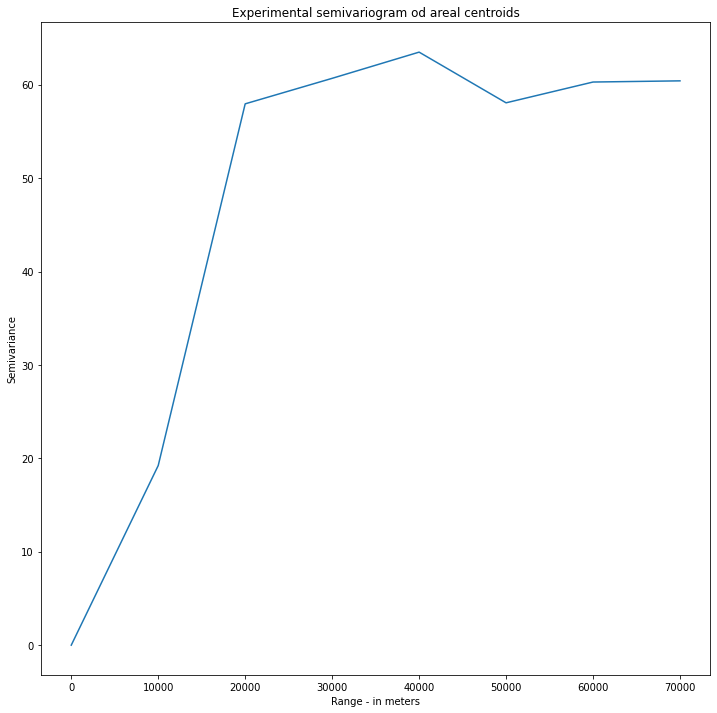

In [52]:
# Check experimental semivariogram of areal data - this cell may be run multiple times 
# before you find optimal parameters

maximum_range = 80000
step_size = 10000
lags = np.arange(0, maximum_range, step_size)

dt = areal_data_prepared[:, 2:]  # x, y, val
exp_semivar = calculate_semivariance.calculate_semivariance(data=dt,
                                                           lags=lags,
                                                           step_size=step_size)

# Plot experimental semivariogram

plt.figure(figsize=(12, 12))
plt.plot(exp_semivar[:, 0], exp_semivar[:, 1])
plt.title('Experimental semivariogram od areal centroids')
plt.xlabel('Range - in meters')
plt.ylabel('Semivariance')
plt.show()

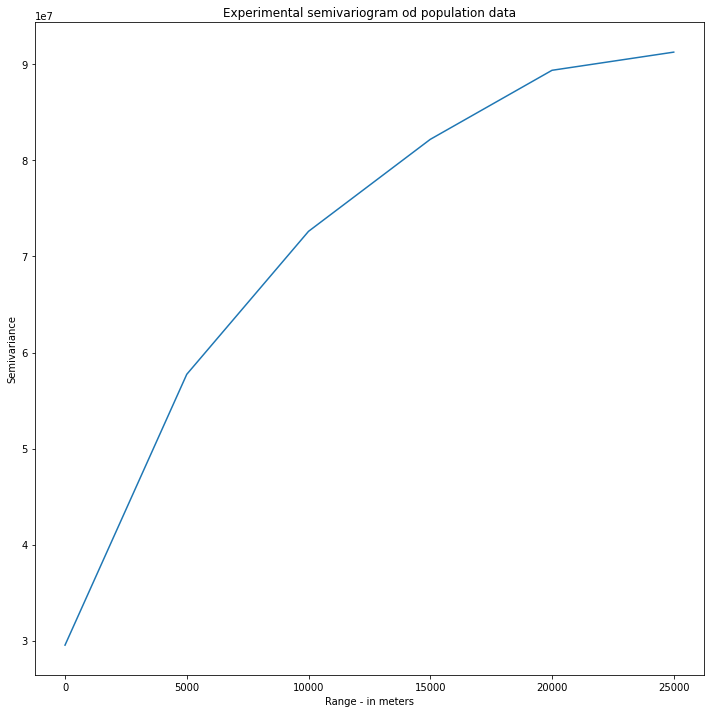

In [51]:
# Check experimental semivariogram of point data - this cell may be run multiple times 
# before you find optimal parameters

def build_point_array(points):
    a = None

    for rec in points:
        if a is None:
            a = rec.copy()
        else:
            a = np.vstack((a, rec))

    return a

maximum_point_range = 30000
step_size_points = 5000
lags_points = np.arange(0, maximum_point_range, step_size_points)


pt = build_point_array(points_in_area[:, 1])  # x, y, val
exp_semivar = calculate_semivariance.calculate_semivariance(data=pt,
                                                           lags=lags_points,
                                                           step_size=step_size_points)

# Plot experimental semivariogram

plt.figure(figsize=(12, 12))
plt.plot(exp_semivar[:, 0], exp_semivar[:, 1])
plt.title('Experimental semivariogram od population data')
plt.xlabel('Range - in meters')
plt.ylabel('Semivariance')
plt.show()

### Clarification:

After few adjustements we have prepared semivariogram parameters for areal and point support data. The next step is to create RegularizedSemivariogram model. We have mutiple parameters to choose and at the beginning it is hard to find the best fit, so try to avoid multiple loops because it is a time-consuming operation.

Parameters are:
* ranges - number of closest neighbors to analyze,
* loop_limit - max number of loops per regularization,
* min_no_of_loops - min number of loops before algorithm returns output,
* number_of_loops_with_const_mean - if mean of deviation will be the same by those number of iterations then algorithm is stopped,
* weighted_semivarioance - if True then errors near origin have greater weights than errors in the distant parts of a semivariogram,
* verbose - if True then algorithm informs about each iteration.

We start with 10 loops, 3 loops with constant mean and minimum number of 5 loops. We take into account 8 neighbors in our analysis

## 3) Regularize semivariogram

In [53]:
reg_mod = RegularizedSemivariogram(ranges=8, loop_limit=10, min_no_loops=5,
                                   number_of_loops_with_const_mean=3,
                                   weighted_semivariance=True, verbose=True)

In [54]:
smvs = reg_mod.regularize_model(areal_data_prepared, lags, step_size,
                                points_in_area, lags_points, step_size_points)

>> Semivariogram Deconvolution <<

##################

Computation of experimental semivariogram of areal data...

Fitting theoretical model to the areal data

Model: spherical, error value: 3.818446304012546
Model: exponential, error value: 4.969524576221936
Model: linear, error value: 3.9757649560223123
Chosen model: spherical, with value: 3.818446304012546.
Setting of the initial point support model

Areal Semivariance fitting to the initial point support model

Deviation estimation

Start of deviation calculation
Calculated deviation is: 14.787733677869873
Setting up optimal models

Semivariogram rescalling...

Computation of experimental semivariogram of rescalled data...

Model: spherical, error value: 1.4262427453525612
Model: exponential, error value: 2.097167578260914
Model: linear, error value: 1.604581129245347
Chosen model: spherical, with value: 1.4262427453525612.
Regularization of the rescalled model

Difference statistics calculation...

Start of deviation calculation
C

**NOTE:**

Operation is slow in the beta version of library so try to find some different task to do when process runs.

## 4) Visualize and check semivariogram

### Clarification:

Process is fully automatic but we can check how it baheaved through each iteration. We can analyze deviation change (most important variable, mean absolute difference between regularized and theoretical models) with build-in method but if you are more interested in the algorithm stability you can analyze weight change over each iteration too.

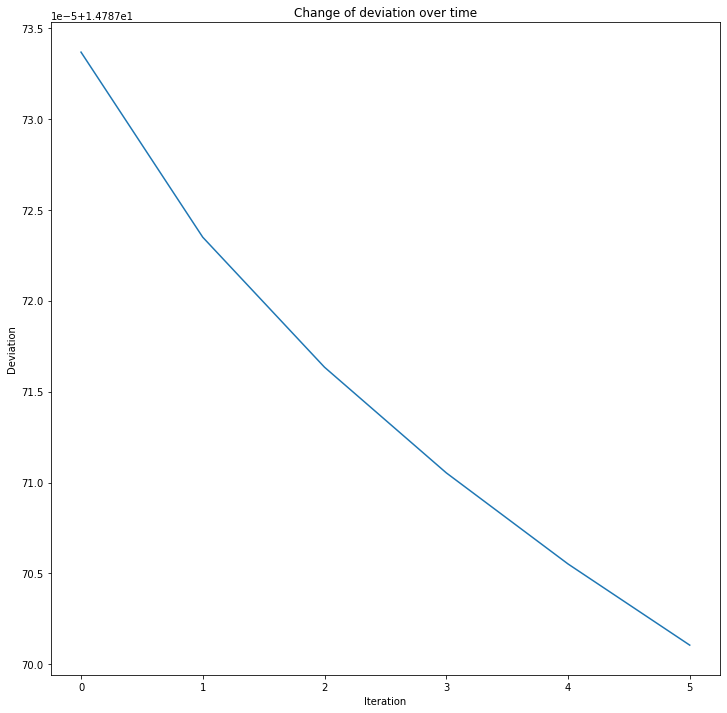

In [55]:
# First analyze deviation

reg_mod.show_deviation()

### Clarification:

Changes in deviation are really small. Probably one iteration should be enough to obtain meaningful results.

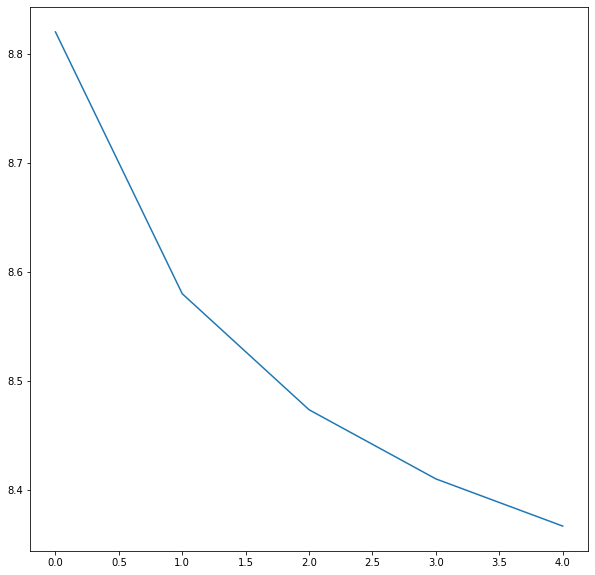

In [63]:
# Check weights - it is important to track problems with algorithm, esepcially if sum of weights is oscillating
# then it may be a sign of problems with data, model or (hopefully not!) algorithm itself

weights = reg_mod.weights
weights = [sum(w) for w in weights]

plt.figure(figsize=(10,10))
plt.plot(weights)
plt.show()

**NOTE:**

The most important part is to compare semivariograms! Let's do it.

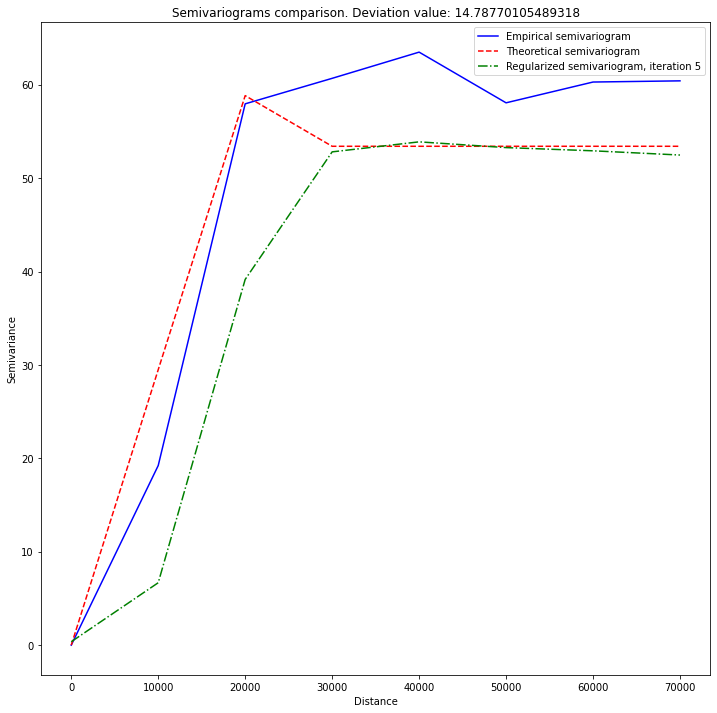

In [64]:
reg_mod.show_semivariograms()

### Clarification:

Empirical semivariogram is a semivariogram of areal centroids. Then theoretical semivariogram is used to describe empirical semivariogram. Regularization process is to find semivariogram close enough to the theoretical semivariogram, which describes ongoing process with the new support (in this case with population units). We found it and now we can store this semivariogram properties for the further analysis and Kriging.

## 5) Export semivariogram to text file

In [66]:
# Export semivariogram to the text file. This is important step because calculations are slow...
# and it is better to not repeat them.
# We will use buil-in method: export_regularized where we pass only filename our semivariogram
# parameters are stored for other tasks.

reg_mod.export_regularized('regularized_semivariogram.csv')

Model exported to file: regularized_semivariogram.csv
